### Library Import하기

In [225]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

# 한글 폰트 설정
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
elif platform.system() == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
else:  # Linux
    rc('font', family='NanumGothic')

# 음수 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance


# 데이터 로드

## 기존 데이터

In [226]:
train_path = r'C:\Users\subon\Downloads\data\train.csv'
test_path  = r'C:\Users\subon\Downloads\data\test.csv'
dt = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

## 추가 데이터

In [227]:
# 버스, 지하철
bus_path = r'C:\Users\subon\Downloads\data\bus_feature.csv'
subway_path = r'C:\Users\subon\Downloads\data\subway_feature.csv'
dt_bus = pd.read_csv(bus_path)
dt_subway = pd.read_csv(subway_path)

In [228]:
# 기준 금리
base_rate = r'C:\Users\subon\Downloads\base_rate.xlsx'
dt_rate = pd.read_excel(base_rate, header=None)

In [229]:
dt_bus.shape, dt_subway.shape

((12584, 6), (768, 5))

# 데이터 확인

- Test, Train 데이터 나누기

In [230]:
dt['is_test']=0
dt_test['is_test']=1
concat = pd.concat([dt, dt_test])

## 컬럼 일부 수정

In [231]:
concat = concat.rename(columns={'전용면적(㎡)':'전용면적'})

# 데이터 전처리

- 결측치 확인

In [232]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

- x,y 좌표 결측치 채우기

In [233]:
xy_path = r'C:\Users\subon\Downloads\xycoord.csv'
dt_xy = pd.read_csv(xy_path, encoding='cp949')

In [234]:
#시군구와 번지를 기준으로 concat와 dt_xy를 병합
merged_df = pd.merge(concat, dt_xy[['시군구', '번지', 'x', 'y']], how='left', on=['시군구', '번지'])

#좌표X와 좌표Y가 결측치인 경우에만 dt_xy에서 가져온 x,y값으로 채우기
concat['좌표X'].fillna(merged_df['x'], inplace=True)
concat['좌표Y'].fillna(merged_df['y'], inplace=True)

In [235]:
concat.isnull().sum()

시군구                             0
번지                            227
본번                             75
부번                             75
아파트명                         2136
전용면적                            0
계약년월                            0
계약일                             0
층                               0
건축년도                            0
도로명                             0
해제사유발생일                   1121899
등기신청일자                          0
거래유형                            0
중개사소재지                          0
k-단지분류(아파트,주상복합등등)         877273
k-전화번호                     876850
k-팩스번호                     879348
단지소개기존clob                1058958
k-세대타입(분양형태)               876125
k-관리방식                     876125
k-복도유형                     876454
k-난방방식                     876125
k-전체동수                     877207
k-전체세대수                    876125
k-건설사(시공사)                 877637
k-시행사                      877834
k-사용검사일-사용승인일              876259
k-연면적                      876125
k-주거전용면적      

- 필요없는 컬럼 삭제

In [236]:
# 첫 글자가 'k'로 시작하는 열 삭제
cols_to_drop = [col for col in concat.columns if col.startswith('k')]
concat.drop(columns=cols_to_drop, inplace=True)

- 필요한 컬럼만 select

In [237]:
#남길 열들의 리스트
columns_to_keep = ['시군구','아파트명', '전용면적', '계약년월', '층','건축년도','도로명','건축면적', '주차대수', '좌표X', '좌표Y', 'target','is_test']

#해당 열들만 남기고 나머지 열 삭제
concat = concat[columns_to_keep]

In [238]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 13 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   시군구      1128094 non-null  object 
 1   아파트명     1125958 non-null  object 
 2   전용면적     1128094 non-null  float64
 3   계약년월     1128094 non-null  int64  
 4   층        1128094 non-null  int64  
 5   건축년도     1128094 non-null  int64  
 6   도로명      1128094 non-null  object 
 7   건축면적     251815 non-null   float64
 8   주차대수     251817 non-null   float64
 9   좌표X      1109546 non-null  float64
 10  좌표Y      1109546 non-null  float64
 11  target   1118822 non-null  float64
 12  is_test  1128094 non-null  int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 120.5+ MB


# Feature Engineering

### '구'와 '동' 분리

In [239]:
#print(concat['시군구'])

#'시군구'에서 '서울특별시' 제거, '구'와 '동'으로 나누기
concat['구'] = concat['시군구'].str.split(' ').str[1]  # '구' 부분 추출
concat['동'] = concat['시군구'].str.split(' ').str[2]  # '동' 부분 추출

# 2. '계약년월'에서 연도 추출 후 건축년도와의 차이를 계산하여 '구매당시 아파트 나이' 열 추가
concat['계약연도'] = concat['계약년월'].astype(str).str[:4].astype(int)  # 계약년월에서 연도만 추출
concat['구매당시 아파트 나이'] = concat['계약연도'] - concat['건축년도']  # 건축년도와의 차이 계산

concat.drop(columns=['시군구','건축년도'], inplace=True)

# 결과 확인
concat.head(5)

,아파트명,전용면적,계약년월,층,도로명,건축면적,주차대수,좌표X,좌표Y,target,is_test,구,동,계약연도,구매당시 아파트 나이
0,개포6차우성,79.97,201712,3,언주로 3,4858.0,262.0,127.05721,37.476763,124000.0,0,강남구,개포동,2017,30
1,개포6차우성,79.97,201712,4,언주로 3,4858.0,262.0,127.05721,37.476763,123500.0,0,강남구,개포동,2017,30
2,개포6차우성,54.98,201712,5,언주로 3,4858.0,262.0,127.05721,37.476763,91500.0,0,강남구,개포동,2017,30
3,개포6차우성,79.97,201801,4,언주로 3,4858.0,262.0,127.05721,37.476763,130000.0,0,강남구,개포동,2018,31
4,개포6차우성,79.97,201801,2,언주로 3,4858.0,262.0,127.05721,37.476763,117000.0,0,강남구,개포동,2018,31


### 기준금리

- 계약년월에 맞게 기준금리 값 추가하기

In [240]:
#첫 번째 행을 '날짜', 두 번째 행을 '기준금리'로 변환
dt_rate = pd.DataFrame({
    '날짜' : dt_rate.iloc[0, :].values, #세로로 변환
    '기준금리' : dt_rate.iloc[1, :].values
})

dt_rate.reset_index(drop=True, inplace=True)

print(dt_rate.head())

        날짜  기준금리
0  200701월  4.50
1  200702월  4.50
2  200703월  4.50
3  200704월  4.50
4  200705월  4.50


In [241]:
#날짜에서 '월' 지우기
dt_rate['날짜']=dt_rate['날짜'].str.replace('월','')

In [242]:
#데이터타입 일치시키기
dt_rate['날짜'] = dt_rate['날짜'].astype(int)
concat['계약년월'] = concat['계약년월'].astype(int)

# 병합 과정에서 누락되는 것을 방지하기 위해, 계약년월과 기준금리가 일치하는지 직접 확인하는 방식으로 병합
concat['기준금리'] = concat['계약년월'].map(dt_rate.set_index('날짜')['기준금리'])

#날짜 컬럼 제거
#concat.drop(columns='날짜', inplace=True)

#기준금리 데이터타입 변환
concat['기준금리']= concat['기준금리'].astype(float)

#결과 출력
print(concat.head(5))

# 결측치 확인
print(f"기준금리 결측치 수: {concat['기준금리'].isnull().sum()}")

     아파트명   전용면적    계약년월  층    도로명    건축면적   주차대수        좌표X        좌표Y  \
0  개포6차우성  79.97  201712  3  언주로 3  4858.0  262.0  127.05721  37.476763   
1  개포6차우성  79.97  201712  4  언주로 3  4858.0  262.0  127.05721  37.476763   
2  개포6차우성  54.98  201712  5  언주로 3  4858.0  262.0  127.05721  37.476763   
3  개포6차우성  79.97  201801  4  언주로 3  4858.0  262.0  127.05721  37.476763   
4  개포6차우성  79.97  201801  2  언주로 3  4858.0  262.0  127.05721  37.476763   

     target  is_test    구    동  계약연도  구매당시 아파트 나이  기준금리  
0  124000.0        0  강남구  개포동  2017           30   1.5  
1  123500.0        0  강남구  개포동  2017           30   1.5  
2   91500.0        0  강남구  개포동  2017           30   1.5  
3  130000.0        0  강남구  개포동  2018           31   1.5  
4  117000.0        0  강남구  개포동  2018           31   1.5  
기준금리 결측치 수: 0


In [243]:
concat.isnull().sum()

아파트명             2136
전용면적                0
계약년월                0
층                   0
도로명                 0
건축면적           876279
주차대수           876277
좌표X             18548
좌표Y             18548
target           9272
is_test             0
구                   0
동                   0
계약연도                0
구매당시 아파트 나이         0
기준금리                0
dtype: int64

### 버스, 지하철 접근성

In [244]:
import pandas as pd
import numpy as np
from shapely.geometry import Point
import geopandas as gpd
from geopandas.tools import sjoin
import pyproj
from tqdm import tqdm

def preprocess_data(df, x_col, y_col):
    wgs84 = pyproj.CRS('EPSG:4326')  # WGS84 좌표계 (위도, 경도)
    utm_k = pyproj.CRS('EPSG:5179')  # UTM-K 좌표계 (한국)
    project = pyproj.Transformer.from_crs(wgs84, utm_k, always_xy=True).transform
    
    df['geometry'] = df.apply(lambda row: Point(project(row[x_col], row[y_col])), axis=1)
    return gpd.GeoDataFrame(df, geometry='geometry', crs=utm_k)

def calculate_density(gdf_real_estate, gdf_locations, radius):
    gdf_real_estate['buffer'] = gdf_real_estate.geometry.buffer(radius)
    
    joined = sjoin(gdf_locations, gdf_real_estate.set_geometry('buffer'), how='inner', predicate='within')
    
    density = joined.groupby(joined.index_right).size().rename('density')
    
    return gdf_real_estate.join(density, how='left').fillna(0)['density']

def process_in_chunks(df, locations_gdf, radius, chunk_size=10000):
    results = []
    for i in tqdm(range(0, len(df), chunk_size)):
        chunk = df.iloc[i:i+chunk_size]
        chunk_gdf = preprocess_data(chunk, '좌표X', '좌표Y')
        density = calculate_density(chunk_gdf, locations_gdf, radius)
        results.append(density)
    return pd.concat(results)

# 버스 정류장과 지하철역 데이터 전처리
bus_gdf = preprocess_data(dt_bus, 'X좌표', 'Y좌표')  # 버스 정류장 좌표계 변환

# 지하철 데이터는 위도, 경도 데이터를 X, Y로 변환
subway_gdf = preprocess_data(dt_subway, '경도', '위도')  # 지하철 데이터도 동일하게 좌표 변환

# 반경 설정
bus_radius = 500  # 미터 단위
subway_radius = 1000  # 1km를 미터 단위로 표현

# 청크 크기 설정
chunk_size = 10000

print("버스 정류장 밀도 계산 중 (500m 반경)...")
concat['bus_stop_density_500m'] = process_in_chunks(concat, bus_gdf, bus_radius, chunk_size)

print("지하철역 밀도 계산 중 (1km 반경)...")
concat['subway_station_density_1km'] = process_in_chunks(concat, subway_gdf, subway_radius, chunk_size)

# 결과 출력
print(concat[['좌표X', '좌표Y', 'bus_stop_density_500m', 'subway_station_density_1km']].head())

버스 정류장 밀도 계산 중 (500m 반경)...


100%|█████████████████████████████████████████| 113/113 [01:29<00:00,  1.27it/s]


지하철역 밀도 계산 중 (1km 반경)...


100%|█████████████████████████████████████████| 113/113 [01:06<00:00,  1.69it/s]


         좌표X        좌표Y  bus_stop_density_500m  subway_station_density_1km
0  127.05721  37.476763                   13.0                         0.0
1  127.05721  37.476763                   13.0                         0.0
2  127.05721  37.476763                   13.0                         0.0
3  127.05721  37.476763                   13.0                         0.0
4  127.05721  37.476763                   13.0                         0.0


### 강남 여부

In [245]:
all = list(concat['구'].unique())
gangnam = ['강서구', '영등포구', '동작구', '서초구', '강남구', '송파구', '강동구']
gangbuk = [x for x in all if x not in gangnam]

assert len(all) == len(gangnam) + len(gangbuk) 

In [246]:
# 강남의 여부를 체크합니다.
is_gangnam = []
for x in concat['구'].tolist() :
  if x in gangnam :
    is_gangnam.append(1)
  else :
    is_gangnam.append(0)

# 파생변수를 하나 만릅니다.
concat['강남여부'] = is_gangnam

In [247]:
concat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 9271
Data columns (total 19 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   아파트명                        1125958 non-null  object 
 1   전용면적                        1128094 non-null  float64
 2   계약년월                        1128094 non-null  int32  
 3   층                           1128094 non-null  int64  
 4   도로명                         1128094 non-null  object 
 5   건축면적                        251815 non-null   float64
 6   주차대수                        251817 non-null   float64
 7   좌표X                         1109546 non-null  float64
 8   좌표Y                         1109546 non-null  float64
 9   target                      1118822 non-null  float64
 10  is_test                     1128094 non-null  int64  
 11  구                           1128094 non-null  object 
 12  동                           1128094 non-null  object 
 13  

# 보간

In [248]:
# 먼저, 연속형 변수와 범주형 변수를 위 info에 따라 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적', '계약년월', '층', '건축면적', '주차대수', '좌표X', '좌표Y', 'target', 'is_test', '계약연도', '구매당시 아파트 나이', '기준금리', 'bus_stop_density_500m', 'subway_station_density_1km', '강남여부']
범주형 변수: ['아파트명', '도로명', '구', '동']


In [249]:
# 범주형 변수에 대한 보간
concat[categorical_columns] = concat[categorical_columns].fillna('NULL')

# 연속형 변수에 대한 보간 (선형 보간)
concat[continuous_columns] = concat[continuous_columns].interpolate(method='linear', axis=0)

In [250]:
concat.isnull().sum()         # 결측치가 보간된 모습을 확인해봅니다.

아파트명                          0
전용면적                          0
계약년월                          0
층                             0
도로명                           0
건축면적                          0
주차대수                          0
좌표X                           0
좌표Y                           0
target                        0
is_test                       0
구                             0
동                             0
계약연도                          0
구매당시 아파트 나이                   0
기준금리                          0
bus_stop_density_500m         0
subway_station_density_1km    0
강남여부                          0
dtype: int64

In [273]:
concat = concat.drop(columns=['좌표X', '좌표Y'])

# 학습

In [274]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat.query('is_test==0')
dt_test = concat.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1118822, 16) (9272, 16)


In [275]:
dt_test['target'] = 0

In [276]:
categorical_columns.remove('구')
categorical_columns

ValueError: list.remove(x): x not in list

## 데이터 변환 및 정규화

### one-hot encoding

In [277]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm( categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( dt_train[col].astype(str) )
    dt_train[col] = lbl.transform(dt_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(dt_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    dt_test[col] = lbl.transform(dt_test[col].astype(str))

100%|█████████████████████████████████████████████| 3/3 [00:01<00:00,  1.67it/s]


In [278]:
# one-hot 인코딩
categorical_columns_1 = ['구']
dt_train = pd.get_dummies(dt_train, columns=categorical_columns_1, drop_first=False)
dt_train

,아파트명,전용면적,계약년월,층,도로명,건축면적,주차대수,target,동,계약연도,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,328,79.97,201712,3,6176,4858.0,262.0,124000.0,8,2017,...,0,0,0,0,0,0,0,0,0,0
1,328,79.97,201712,4,6176,4858.0,262.0,123500.0,8,2017,...,0,0,0,0,0,0,0,0,0,0
2,328,54.98,201712,5,6176,4858.0,262.0,91500.0,8,2017,...,0,0,0,0,0,0,0,0,0,0
3,328,79.97,201801,4,6176,4858.0,262.0,130000.0,8,2018,...,0,0,0,0,0,0,0,0,0,0
4,328,79.97,201801,2,6176,4858.0,262.0,117000.0,8,2018,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118817,215,59.94,200707,11,4816,0.0,366.0,20000.0,21,2007,...,0,0,0,0,0,0,1,0,0,0
1118818,215,59.94,200708,10,4816,0.0,366.0,20000.0,21,2007,...,0,0,0,0,0,0,1,0,0,0
1118819,215,84.83,200708,20,4816,0.0,366.0,28000.0,21,2007,...,0,0,0,0,0,0,1,0,0,0
1118820,215,84.83,200709,8,4816,0.0,366.0,29000.0,21,2007,...,0,0,0,0,0,0,1,0,0,0


In [279]:
categorical_columns_1 = ['구']
dt_test = pd.get_dummies(dt_test, columns=categorical_columns_1, drop_first=False)
dt_test.head(2)

,아파트명,전용면적,계약년월,층,도로명,건축면적,주차대수,target,동,계약연도,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,328,79.9700,202307,5,6176,4858.00,262.0,0,8,2023,...,0,0,0,0,0,0,0,0,0,0
1,329,108.2017,202308,10,469,2724.46,305.0,0,8,2023,...,0,0,0,0,0,0,0,0,0,0


### 정규화

In [258]:
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
# 연속형 변수 정규화
#scaler = StandardScaler()
#concat[continuous_columns] = scaler.fit_transform(concat[continuous_columns])

- 특이 저가 거래 drop시키기

# EDA

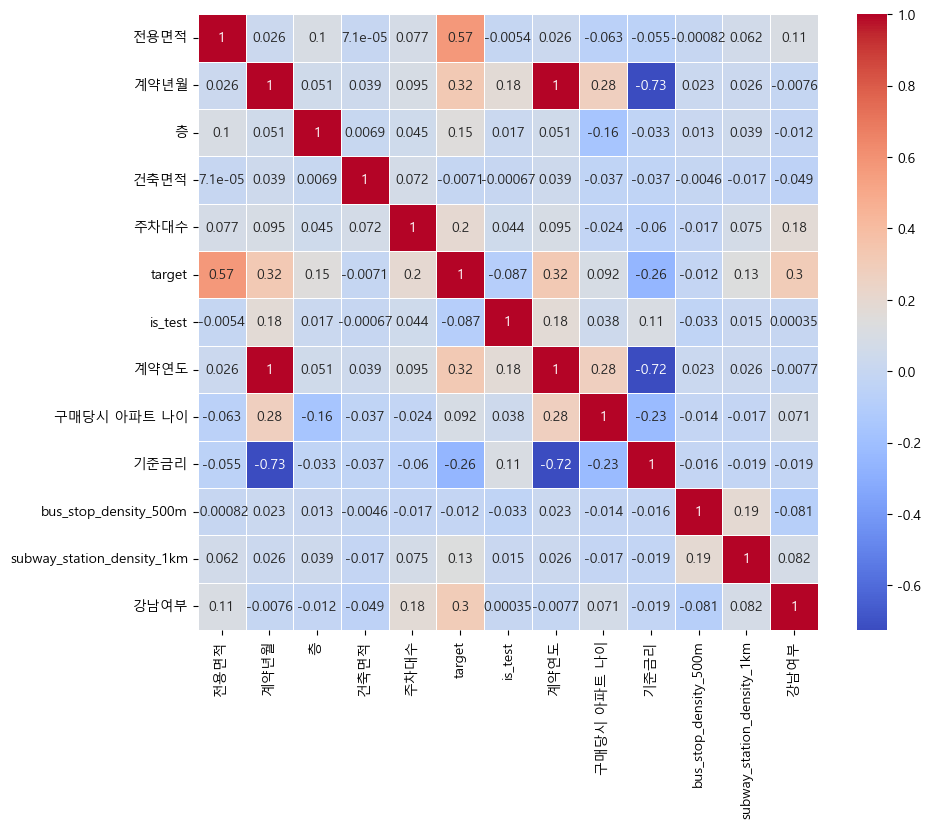

In [280]:
# 상관계수 행렬 계산
corr_matrix = concat.corr()

# 상관계수 행렬 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)

# 결과 출력
plt.show()

# 모델 학습

In [260]:
# 기준금리와 다른 변수 간 상호작용 변수 추가 (예: 기준금리와 주택 면적의 상호작용)
#dt_train['기준금리와날짜'] = dt_train['기준금리'] * dt_train['계약년월']
#dt_test['기준금리와날짜'] = dt_test['기준금리'] * dt_test['계약년월']

In [281]:
# 같음
assert dt_train.shape[1] == dt_test.shape[1]

In [282]:
# Target과 독립변수들을 분리해줍니다.
y_train = dt_train['target']
X_train = dt_train.drop(['target'], axis=1)

# Hold out split을 사용해 학습 데이터와 검증 데이터를 8:2 비율로 나누겠습니다.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [283]:
# 파생 변수가 생성되었는지 확인
#print(dt_train[['기준금리','기준금리와날짜']].head())


- 비선형 모델

In [284]:
# RandomForestRegressor를 이용해 회귀 모델을 적합시키겠습니다.
model = RandomForestRegressor(n_estimators=5, criterion='squared_error', random_state=1, n_jobs=-1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

In [285]:
# 회귀 관련 metric을 통해 train/valid의 모델 적합 결과를 관찰합니다.
print(f'RMSE test: {np.sqrt(metrics.mean_squared_error(y_val, pred))}')

RMSE test: 8396.787948470368


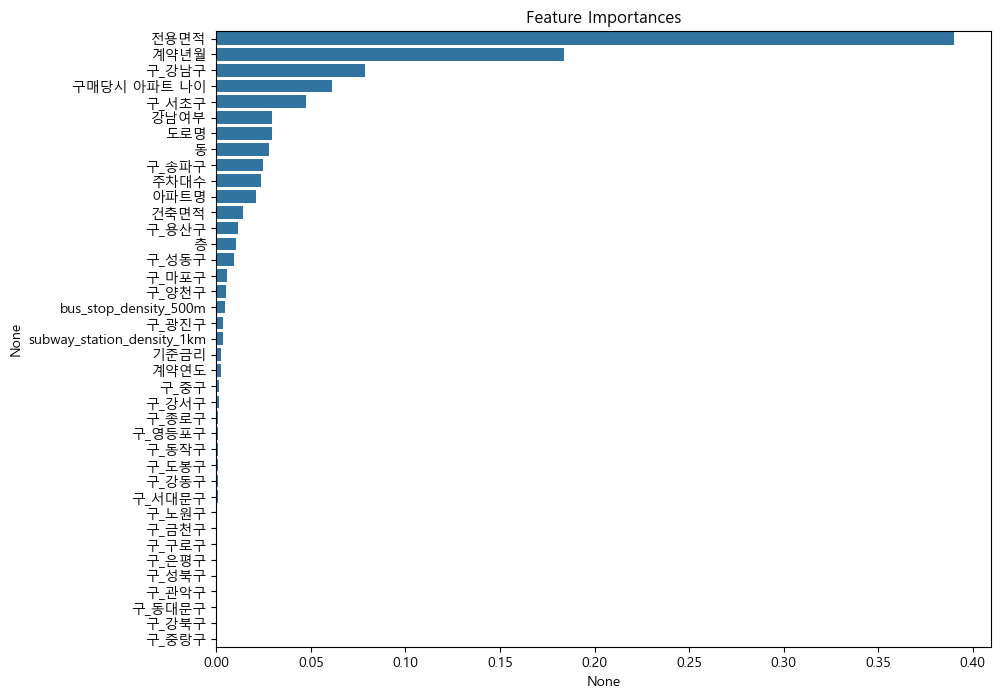

In [286]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

- 다른 모델 확인

from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
import lightgbm as lgb

# XGBoost Regressor
xgboost_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=1, n_jobs=-1)
xgboost_model.fit(X_train, y_train)
xgboost_pred = xgboost_model.predict(X_val)
xgboost_rmse = np.sqrt(mean_squared_error(y_val, xgboost_pred))
print(f"XGBoost RMSE: {xgboost_rmse}")

# CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=100, learning_rate=0.1, random_seed=1, verbose=0)
catboost_model.fit(X_train, y_train)
catboost_pred = catboost_model.predict(X_val)
catboost_rmse = np.sqrt(mean_squared_error(y_val, catboost_pred))
print(f"CatBoost RMSE: {catboost_rmse}")

# LightGBM Regressor
lightgbm_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=1)
lightgbm_model.fit(X_train, y_train)
lightgbm_pred = lightgbm_model.predict(X_val)
lightgbm_rmse = np.sqrt(mean_squared_error(y_val, lightgbm_pred))
print(f"LightGBM RMSE: {lightgbm_rmse}")

#GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=1)
gbr_model.fit(X_train, y_train)
gbr_pred = gbr_model.predict(X_val)
gbr_rmse = np.sqrt(mean_squared_error(y_val, gbr_pred))
print(f"gbr RMSE: {gbr_rmse}")

- 선형 모델

from sklearn.linear_model import LinearRegression, Ridge, Lasso
#Linear 모델
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_val)

#Ridge 모델
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
pred = model.predict(X_val)

#Lasso 모델
model = Lasso(alpha=0.1)
model.fit(X_train, y_train)
pred = model.predict(X_val)

# 결과 확인 및 추출

In [287]:
# 학습된 모델을 저장합니다. Pickle 라이브러리를 이용하겠습니다.
with open('saved_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [288]:
dt_test.head(2)

,아파트명,전용면적,계약년월,층,도로명,건축면적,주차대수,target,동,계약연도,...,구_성동구,구_성북구,구_송파구,구_양천구,구_영등포구,구_용산구,구_은평구,구_종로구,구_중구,구_중랑구
0,328,79.9700,202307,5,6176,4858.00,262.0,0,8,2023,...,0,0,0,0,0,0,0,0,0,0
1,329,108.2017,202308,10,469,2724.46,305.0,0,8,2023,...,0,0,0,0,0,0,0,0,0,0


In [289]:
# 저장된 모델을 불러옵니다.
with open('saved_model.pkl', 'rb') as f:
    model = pickle.load(f)

In [290]:
%%time
X_test = dt_test.drop(['target'], axis=1)

# Test dataset에 대한 inference를 진행합니다.
real_test_pred = model.predict(X_test)

CPU times: total: 0 ns
Wall time: 13.9 ms


In [291]:
real_test_pred

array([190900., 286700., 359600., ..., 105300.,  69600.,  78130.])

In [292]:
# 앞서 예측한 예측값들을 저장합니다.
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('output.csv', index=False)